# Overview

2章

# Params

In [159]:
# color palette
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
CHALLENGER_DATASET_PATH = '../../data/Chapter2_MorePyMC/challenger_data.csv'

# Import everything I need :)

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import seaborn as sns
import pymc3 as pm
import daft
import theano.tensor as tt

# my function

In [236]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

# Preparation

In [82]:
mpl.rcParams['axes.facecolor'] = 'ffffff' 
sns.set()

# Do it

## モデリング

- 1章でやったメールの受信数のモデルを使ったサンプリング
- 学習は行っていないことに注意

<br>

下記のグラフィカルモデルをモデリングする

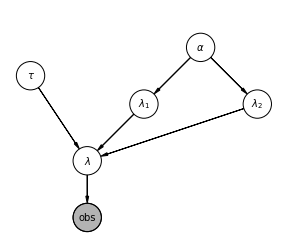

In [35]:
# pgm = daft.PGM(shape=[6,6])
pgm = daft.PGM(shape=[5, 4])
# Nodes
pgm.add_node(daft.Node("alpha", r"$\alpha$", 4, 5)) # 名前　ラベル　座標
pgm.add_node(daft.Node("tau", r"$\tau$", 1, 4.5))
pgm.add_node(daft.Node("lambda_1", r"$\lambda_1$", 3, 4))
pgm.add_node(daft.Node("lambda_2", r"$\lambda_2$", 5, 4))
pgm.add_node(daft.Node("lambda",  r"$\lambda$", 2, 3))
pgm.add_node(daft.Node("obs", "obs", 2, 2, observed=True))

# Edges
pgm.add_edge("alpha", "lambda_1")
pgm.add_edge("alpha", "lambda_2")
pgm.add_edge("tau", "lambda")
pgm.add_edge("lambda_1", "lambda")
pgm.add_edge("lambda_2", "lambda")
pgm.add_edge("lambda", "obs")

pgm.render()
pgm.figure.set_facecolor('white')

In [57]:
tau = np.random.randint(0, 80)
print(tau)

45


2\. Draw $\lambda_1$ and $\lambda_2$ from an $\text{Exp}(\alpha)$ distribution:

In [58]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

8.556604671060105 2.067731858147741


3\.  For days before $\tau$, represent the user's received SMS count by sampling from $\text{Poi}(\lambda_1)$, and sample from  $\text{Poi}(\lambda_2)$ for days after $\tau$. For example:

In [59]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

4\. Plot the artificial dataset:

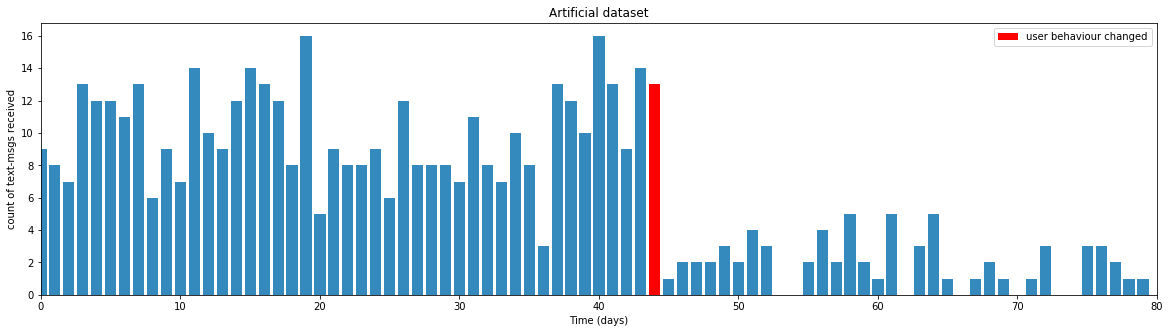

In [60]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

---> 上記の図は実行するごとに変わる。  
---> グラフィカルモデルの、$\tau$をランダムに取得しその値を使って $\lambda_1, \lambda_2$をランダムに取得。それらの値と、ランダムに取得した$\tau$を使ってランダムな$\lambda$を得る。  
---> 学習では、もとのデータを再現するように、パラメータ$\tau, \lambda_1, \lambda_2$ の事後分布が作られる！！

## A/B テスト

- あるサイトのデザインを新しくした。その効果を確認したい。(商品の購入が行われたかで測る)
- A/Bテストを行った。
- A: 新デザイン
- B: 旧デザイン

<br>

データを作成する  
- A:
    - 買う確率: 0.05
    - サンプル数: 1500
- B:
    - 買う確率: 0.04
    - サンプル数: 750

- 上記のサンプルの買う確率は実際には、知らないことに注意。

In [133]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 15000
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0] ...


測定の結果 ↑ のデータを取得した。では、解析をしよう。

In [134]:
with pm.Model() as model:
    # 事前分布
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # p_A と p_B が決まれば決定する変数
    delta = pm.Deterministic("delta", p_A - p_B)

    # 観測値(X)
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # サンプリング
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]  # mcmc のゴミ部分を捨てる

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:14<00:00, 5592.70draws/s]
The number of effective samples is smaller than 10% for some parameters.


---> 観測データ、obs_Aとobs_B を説明するための ベルヌーイ分布のパラメータ(p_A と p_B) を知りたいので学習を行った。  
---> メトロポリス法により、事後分布 trace を得た(前半のゴミを覗いたやつは、burned_trace)

In [135]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

---> 3つの変数の事後分布を取得

In [150]:
# 事前分布
p_dist = [p_A.random() for _ in range(100000)]

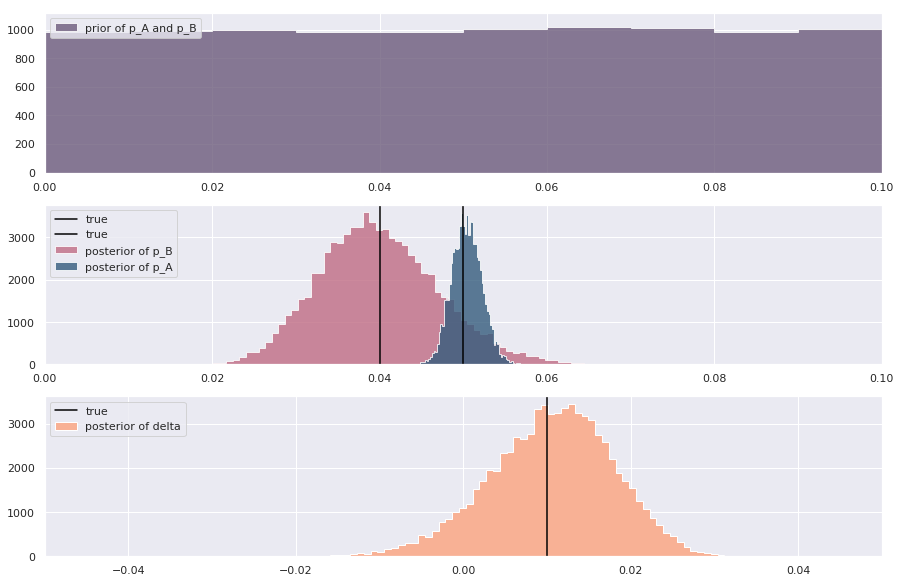

In [158]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs = axs.ravel()

axs[0].hist(p_dist, bins=100, color=cp[3], histtype='stepfilled', label='prior of p_A and p_B', alpha=0.8)
axs[1].hist(p_B_samples, bins=70, color=cp[2], histtype='stepfilled', label='posterior of p_B', alpha=0.8)
axs[1].hist(p_A_samples, bins=70, color=cp[4], histtype='stepfilled', label='posterior of p_A', alpha=0.8)
axs[2].hist(delta_samples, bins=70, color=cp[0], histtype='stepfilled', label='posterior of delta')

axs[1].axvline(true_p_A, color='black', label='true')
axs[1].axvline(true_p_B, color='black', label='true')
axs[2].axvline(true_p_A-true_p_B, color='black', label='true')

axs[0].set_xlim(0, 0.1)
axs[1].set_xlim(0, 0.1)
axs[2].set_xlim(-0.05, 0.05)

axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper left')

---> サンプル数の違いが分散に出てる
---> delta が 正なので A の効果があったことになる。  
---> 上図はサンプリングした結果である。deltaの中には0を下回る結果もある(Aの効果がなかったという結果)  
---> 確率がどの程度か確かめてみよう

In [137]:
print(f'サイトAがサイトBよりも悪い確率: {(delta_samples < 0).mean() :.3f}')

サイトAがサイトBよりも悪い確率: 0.085


---> こんな感じになった。  
---> サンプル数増やしたらどうなるか確かめてみるのもいいかも。

<br>
<br>

## チャレンジャー号

- Oリング破損と、外気温(華氏)の関係

Text(0.5, 0, 'Tempreture')

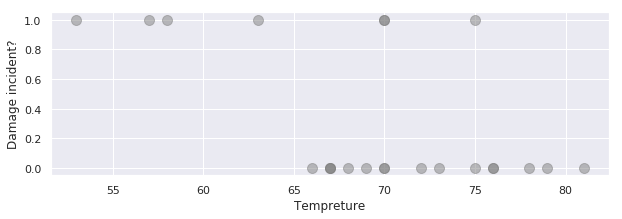

In [225]:
# load data
challenger_data = pd.read_csv(CHALLENGER_DATASET_PATH)

# remove nan
idxs_nan = np.logical_not(challenger_data['Damage Incident'].isna())
challenger_data = challenger_data[idxs_nan]

# extract temp and incident
challenger_data = challenger_data[['Temperature', 'Damage Incident']].values[0:-1].astype('int64')

# plot
plt.figure(figsize=(10, 3))
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'o', alpha=0.5, markersize=10, color='gray')
plt.ylabel('Damage incident?')
plt.xlabel('Tempreture')

---> 寒いほうが壊れやすい

<br>

モデリング開始
- ロジスティック回帰を使う
$$
p(t) = \frac{1}{1 + \exp{^{\beta t + \alpha}}}
$$
- 上記の$\beta, \alpha$を決める
- $\beta, \alpha$ は正規分布を仮定する

In [226]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

---> theano のエラー出たけど、data のdtypeを `int64` にすると治った

<br>

観測データと結びつけるために ベルヌーイ分布を使う

In [227]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

logp = -19.024, ||grad|| = 9.9071: 100%|██████████| 27/27 [00:00<00:00, 2437.13it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 482000/482000 [01:09<00:00, 6948.75draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


We have trained our model on the observed data, now we can sample values from the posterior. Let's look at the posterior distributions for $\alpha$ and $\beta$:

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


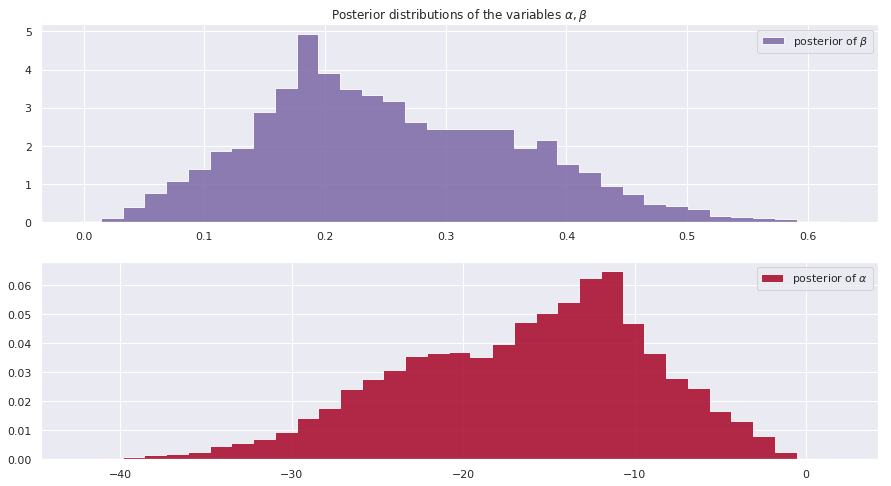

In [229]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

plt.figure(figsize=(15, 8))
#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

信用区間と期待値

In [237]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

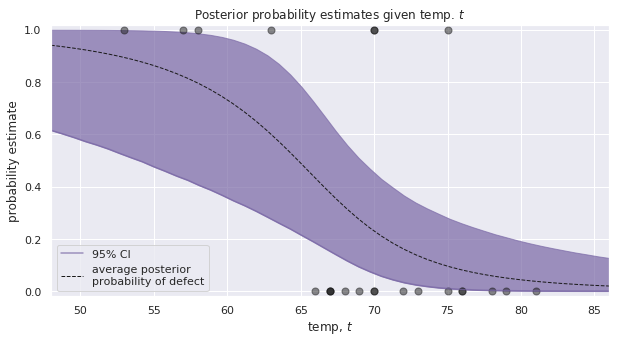

In [240]:
plt.figure(figsize=(10, 5))

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = stats.mstats.mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

<br>

事後分布からシミュレーションデータをサンプリング

In [ ]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]
Sampling 4 chains, 0 divergences:  83%|████████▎ | 35048/42000 [00:21<00:04, 1641.27draws/s]

In [ ]:
simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.figure(figsize=(12.5, 10))
plt.title("Simulated dataset using posterior parameters")
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)